In [8]:
import sys
import os
import importlib   

sys.path.append(os.path.join(os.getcwd(), 'NeuralNetworks'))
import Fully_connected_network as FC
importlib.reload(FC)

import torch
import matplotlib.pyplot as plt

In [43]:
if torch.cuda.is_available():
   device = torch.device("cuda")
   print("Running on the GPU")
else:
   device = torch.device("cpu")
   print("Running on the CPU")

torch.manual_seed(15)
torch.set_default_dtype(torch.float64)

Running on the GPU


In [44]:
def u_exact(x:torch.Tensor):
    # u_g = torch.log(x+2) + torch.cos(2*x + x**3)
    u_g = torch.sin(2*x + 1) + 0.2*torch.exp(1.3*x)
    # u_g = x**3/(0.01 + x**4)
    return u_g

In [45]:
def calculate_kappa(x):
    nb_zeros = torch.where(x[:-1, 0] * x[1:, 0] < 0)[0]
    kappa = 3*(nb_zeros.shape[0])
    return kappa

In [46]:
class OneStageFCNN():
    def __init__(self, x_train, u_train, hidden_size, kappa, lower_bound, upper_bound, activation_func):
        super(OneStageFCNN, self).__init__()

        self.u_scale = torch.max(torch.abs(u_train))/2
        self.loss_scale = self.u_scale**2
        self.x_train = x_train
        self.u_train = u_train/self.u_scale

        self.hidden_size = hidden_size
        self.kappa = kappa
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.activation_func = activation_func

        self.model = FC.FullyConnectedNetwork(domain_bounds=[lower_bound, upper_bound], kappa=kappa, input_dim=1, hidden_size=hidden_size, actv=activation_func) 
        self.model_optimizer = 'defined in train'
        self.loss_criterion = 'defined in train'

    def _adam_train(self, n_iter):
        loss_criterion = self.loss_criterion
        model_optimizer = self.model_optimizer

        for iter_i in range(n_iter):
            model_optimizer.zero_grad()
            u_pred = self.model(self.x_train)
            loss_value = loss_criterion(u_pred, self.u_train) * self.loss_scale
            loss_value.backward()
            model_optimizer.step()

            if iter_i % 100 == 0:
                print(f"Iteration {iter_i}, Loss: {loss_value}")

    def _closure(self):
        self.model_optimizer.zero_grad()
        u_pred = self.model(self.x_train)
        loss_value = self.loss_criterion(u_pred, self.u_train) * self.loss_scale
        loss_value.backward()
        return loss_value
    
    def _lbfgs_train(self, n_iter):
        for iter_i in range(n_iter):
            loss_value = self.model_optimizer.step(self._closure)
            if iter_i % 100 == 0:
                print(f"Iteration {iter_i}, Loss: {loss_value}")

    def train(self, n_iter, method):
        self.loss_criterion = torch.nn.MSELoss()
        if method == 1:
            self.model_optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
            self._adam_train(n_iter)
        elif method == 2:
            self.model_optimizer = torch.optim.LBFGS(self.model.parameters(), lr=0.1, max_iter=n_iter//3, tolerance_grad=1e-11, line_search_fn='strong_wolfe')
            self._lbfgs_train(n_iter)

    def predict(self, x_to_predict):
        u_pred = self.model(x_to_predict) * self.u_scale
        return u_pred



In [47]:
nb_training_points = 1501
x_train = torch.linspace(-1.02, 1.02, nb_training_points).reshape(-1,1)
u_train = u_exact(x_train)

low_bound_xtrain, up_bound_xtrain = x_train.min(), x_train.max()

nb_evaluation_points = 8000
x_eval = torch.linspace(-1, 1, nb_evaluation_points).reshape(-1,1)
u_eval = u_exact(x_eval)

In [48]:
# Fist stage of training

model1 = OneStageFCNN(x_train, u_train, hidden_size=20, kappa=1, lower_bound=low_bound_xtrain, upper_bound=up_bound_xtrain, activation_func=0)
model1.train(5000, 1)
model1.train(1000, 2)
u_pred = model1.predict(x_eval)

Iteration 0, Loss: 0.8357330396734408
Iteration 100, Loss: 0.05516022328886819
Iteration 200, Loss: 0.007067222874688418
Iteration 300, Loss: 0.004586739143014243
Iteration 400, Loss: 0.00405279144753776
Iteration 500, Loss: 0.003626077248883533
Iteration 600, Loss: 0.0032847319076860174
Iteration 700, Loss: 0.003006933693898973
Iteration 800, Loss: 0.0027729198624681906
Iteration 900, Loss: 0.002567018746909208
Iteration 1000, Loss: 0.0023774415520433274
Iteration 1100, Loss: 0.0021950440381769123
Iteration 1200, Loss: 0.0020118321871704036
Iteration 1300, Loss: 0.001819483901270916
Iteration 1400, Loss: 0.0016080247417572192
Iteration 1500, Loss: 0.0013653264943729716
Iteration 1600, Loss: 0.0010801432637915608
Iteration 1700, Loss: 0.0007553862273571919
Iteration 1800, Loss: 0.0004335804652201224
Iteration 1900, Loss: 0.00019262999378263107
Iteration 2000, Loss: 6.849610802748041e-05
Iteration 2100, Loss: 2.3259949295006378e-05
Iteration 2200, Loss: 9.302596467505902e-06
Iteration 2

In [49]:
# Second stage of the training

u_train2 = u_train - model1.predict(x_train).detach()
kappa2 = calculate_kappa(u_train2)

model2 = OneStageFCNN(x_train, u_train2, hidden_size=20, kappa=kappa2, lower_bound=low_bound_xtrain, upper_bound=up_bound_xtrain, activation_func=1)
model2.train(10000, 1)
model2.train(1000, 2)
u_pred2 = model2.predict(x_eval)
u_p = u_pred + u_pred2

Iteration 0, Loss: 2.1784374354485634e-06
Iteration 100, Loss: 1.7231439264269404e-08
Iteration 200, Loss: 5.783707630497033e-09
Iteration 300, Loss: 2.925857774222465e-09
Iteration 400, Loss: 1.748471738296433e-09
Iteration 500, Loss: 1.1074638454408694e-09
Iteration 600, Loss: 7.287184925225701e-10
Iteration 700, Loss: 5.01820707847629e-10
Iteration 800, Loss: 3.6670781523123964e-10
Iteration 900, Loss: 2.844114797639839e-10
Iteration 1000, Loss: 2.3114978233080583e-10
Iteration 1100, Loss: 1.9413234477284138e-10
Iteration 1200, Loss: 1.6676576582114637e-10
Iteration 1300, Loss: 1.4558451952410754e-10
Iteration 1400, Loss: 1.286648037920199e-10
Iteration 1500, Loss: 1.148553935422341e-10
Iteration 1600, Loss: 1.0340976774593091e-10
Iteration 1700, Loss: 9.380854449527717e-11
Iteration 1800, Loss: 8.567106535567484e-11
Iteration 1900, Loss: 7.870869961282629e-11
Iteration 2000, Loss: 7.269801720440289e-11
Iteration 2100, Loss: 6.74638806582095e-11
Iteration 2200, Loss: 6.2867899917242

In [50]:
# Third stage of the training
nb_training_points_strengthening = 4801
x_train_strengthening = torch.linspace(-1.02, 1.02, nb_training_points_strengthening).reshape(-1,1)
u_train_strengthening = u_exact(x_train_strengthening)

u_train3 = u_train_strengthening - model1.predict(x_train_strengthening).detach() - model2.predict(x_train_strengthening).detach()
kappa3 = calculate_kappa(u_train3)

model3 = OneStageFCNN(x_train_strengthening, u_train3, hidden_size=30, kappa=kappa3, lower_bound=low_bound_xtrain, upper_bound=up_bound_xtrain, activation_func=1)
model3.train(5000, 1)
model3.train(1000, 2)
u_pred3 = model3.predict(x_eval)
u_p2 = u_p + u_pred3

Iteration 0, Loss: 7.733722427074805e-11
Iteration 100, Loss: 5.831356735941166e-11
Iteration 200, Loss: 5.118169397964633e-11
Iteration 300, Loss: 3.747928749259483e-11
Iteration 400, Loss: 2.7650310852407906e-11
Iteration 500, Loss: 2.0265922780883927e-11
Iteration 600, Loss: 1.56885093330374e-11
Iteration 700, Loss: 1.3052433734097765e-11
Iteration 800, Loss: 1.1615007413349168e-11
Iteration 900, Loss: 1.0712756933198743e-11
Iteration 1000, Loss: 1.002057403178919e-11
Iteration 1100, Loss: 9.432910795696297e-12
Iteration 1200, Loss: 8.91457274288013e-12
Iteration 1300, Loss: 8.453776413461438e-12
Iteration 1400, Loss: 8.0445846901928e-12
Iteration 1500, Loss: 7.680211524293332e-12
Iteration 1600, Loss: 7.352808174220577e-12
Iteration 1700, Loss: 7.0555108600020945e-12
Iteration 1800, Loss: 6.783767368459697e-12
Iteration 1900, Loss: 6.5351811862509515e-12
Iteration 2000, Loss: 6.308533828124501e-12
Iteration 2100, Loss: 6.10287618800453e-12
Iteration 2200, Loss: 5.9170950750449875e-

In [51]:
# Fourth stage of the training
u_train4 = u_train_strengthening - model1.predict(x_train_strengthening).detach() - model2.predict(x_train_strengthening).detach() - model3.predict(x_train_strengthening).detach()
kappa4 = calculate_kappa(u_train4)

model4 = OneStageFCNN(x_train_strengthening, u_train4, hidden_size=30, kappa=kappa4, lower_bound=low_bound_xtrain, upper_bound=up_bound_xtrain, activation_func=1)
model4.train(5000, 1)
model4.train(1000, 2)
u_pred4 = model4.predict(x_eval)

u_p3 = u_p2 + u_pred4

Iteration 0, Loss: 3.352277723876177e-11
Iteration 100, Loss: 2.7015186430584868e-11
Iteration 200, Loss: 2.233702935128038e-11
Iteration 300, Loss: 1.9515313789327464e-11
Iteration 400, Loss: 1.7598379801782472e-11
Iteration 500, Loss: 1.620684774080026e-11
Iteration 600, Loss: 1.5165922811789343e-11
Iteration 700, Loss: 1.4348448130142723e-11
Iteration 800, Loss: 1.3665882069156688e-11
Iteration 900, Loss: 1.3065967470884291e-11
Iteration 1000, Loss: 1.2521990937754655e-11
Iteration 1100, Loss: 1.2021078858488101e-11
Iteration 1200, Loss: 1.1556401763066011e-11
Iteration 1300, Loss: 1.1123565558335883e-11
Iteration 1400, Loss: 1.0719174535813064e-11
Iteration 1500, Loss: 1.034038768420182e-11
Iteration 1600, Loss: 9.985225359017312e-12
Iteration 1700, Loss: 9.653077922824054e-12
Iteration 1800, Loss: 9.344698045083094e-12
Iteration 1900, Loss: 9.061485787484053e-12
Iteration 2000, Loss: 8.804445157608073e-12
Iteration 2100, Loss: 8.573384942906894e-12
Iteration 2200, Loss: 8.36673663

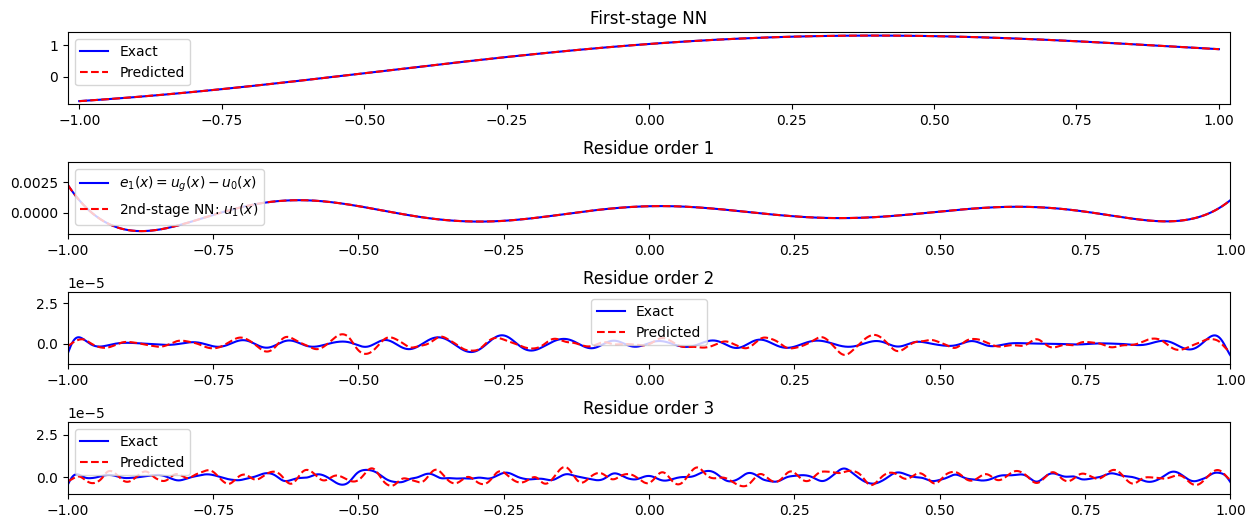

In [52]:
fig, axes = plt.subplots(4, 1, figsize=(15, 6))
fig.subplots_adjust(hspace=0.8)

axes[0].plot(x_eval, u_eval, 'b-', label='Exact')
axes[0].plot(x_eval, u_pred.detach(), 'r--', label='Predicted')
axes[0].set_xlim(low_bound_xtrain, up_bound_xtrain)
axes[0].legend()
axes[0].set_title('First-stage NN')

axes[1].plot(x_train, u_train2.detach(), 'b-', label=r'$e_1(x) = u_g(x) - u_0(x)$')
axes[1].plot(x_eval, u_pred2.detach(), 'r--', label=r'2nd-stage NN: $u_1(x)$')
axes[1].set_xlim(-1, 1)
axes[1].legend()
axes[1].set_title('Residue order 1')

axes[2].plot(x_train_strengthening, u_train3, 'b-', label='Exact')
axes[2].plot(x_eval, u_pred3.detach(), 'r--', label='Predicted')
axes[2].set_xlim(-1, 1)
axes[2].legend()
axes[2].set_title('Residue order 2')

axes[3].plot(x_train_strengthening, u_train4.detach(), 'b-', label='Exact')
axes[3].plot(x_eval, u_pred4.detach(), 'r--', label='Predicted')
axes[3].set_xlim(-1, 1)
axes[3].legend()
axes[3].set_title('Residue order 3')

plt.show()

In [53]:
import numpy as np 
error_u = np.linalg.norm(u_eval - u_pred.detach())/np.linalg.norm(u_eval, 2)
error_u2 = np.linalg.norm(u_eval - u_p2.detach())/np.linalg.norm(u_eval, 2)
error_u3 = np.linalg.norm(u_eval - u_p3.detach())/np.linalg.norm(u_eval, 2)
error_u4 = np.linalg.norm(u_eval - u_p3.detach())/np.linalg.norm(u_eval, 2)

print(f'Error of order 1: {error_u}')
print(f'Error of order 2: {error_u2}')
print(f'Error of order 3: {error_u3}')
print(f'Error of order 4: {error_u4}')

Error of order 1: 0.0006545162686963392
Error of order 2: 1.8140709617466432e-06
Error of order 3: 2.4582510158157564e-06
Error of order 4: 2.4582510158157564e-06
